In [1]:
#imports
import csv
import re
import unicodedata as uc

import numpy as np
import pandas as pd

from io import StringIO
import requests

import math
!pip install textaugment
import textaugment #https://pypi.org/project/textaugment/
import nltk
nltk.download('stopwords')

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

!pip install eli5
import eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 1.4 MB 39.3 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=3ec25101190938cad8c97d32d96a83383eaca82e23a2ddd50dd209a70a8b4df1
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 8.1 MB/s 
     |████████████████████████████████| 133 kB 38.4 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=8b88085733add9ad49dd9d4ef508756fe66179befae288113ae731db7332c13a
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [7]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [8]:
class DataDownloader:
  def __init__(self):
    pass

  def load_dataset(self, url) -> pd.DataFrame:
    """
    DESCRIPTION: Downloads data from URL and creates pandas dataframe
    SOURCE: https://colab.research.google.com/drive/18eTnEKKZFP91nNfmnBFpQ2baw8GmOxtI?usp=sharing&pli=1#scrollTo=BCLdrs43pJC1
    """

    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

DD = DataDownloader()  

In [9]:
class PreProcessing:

  def __init__(self):
    pass

  def clean_tweets(self, data) -> pd.DataFrame:
    """
    DESCRIPTION: Preprocesses tweets such that only language specific text is in it.
    Uses __delete_links, __unicode_normalization, __delete_numbers, __replace_meaningless_char
    Note that list comprehentions are used instead of pandas.apply() as apply is not vectorized and
    list comprehentions make the code approx. 4x faster.
    """
    temp = data.copy(deep=True)
    temp["tweet"] = [self.__delete_links(tweet) for tweet in temp["tweet"].to_list()]
    temp["tweet"] = [self.__delete_twitter_usernames(tweet) for tweet in temp["tweet"].to_list()]
    temp["tweet"] = [self.__delete_hashtags(tweet) for tweet in temp["tweet"].to_list()]
    temp["tweet"] = [self.__unicode_normalization(tweet) for tweet in temp["tweet"].to_list()]
    temp["tweet"] = [self.__delete_numbers(tweet) for tweet in temp["tweet"].to_list()]
    temp["tweet"] = [self.__replace_meaningless_char(tweet) for tweet in temp["tweet"].to_list()]
    temp["tweet"] = [self.__lowercase_string(tweet) for tweet in temp["tweet"].to_list()]

    #some tweets only consist of a single link. By cleaning out all links, these files now only contain spaces.
    #Here these corrupt rows are being deleted
    temp = temp[temp["tweet"] != "  "]
    temp = temp[temp["tweet"] != " "]
    temp = temp[temp["tweet"] != ""]

    return temp

  def __delete_links(self, text) -> str:
    """
    DESCRIPTION: Deletes all links from a message
    Works with any language (e.g. Chinese and Arab)
    SOURCE: https://devenum.com/how-to-extract-url-from-a-string-in-python/
    """
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    return re.sub(pattern = regex, repl = "", string = text)
  
  def __delete_twitter_usernames(self, text) -> str:
    """
    DESCRIPTION: Deletes all twitter Usernames starting with @
    This is needed as twitter usernames are meaningless, don't get cut out in the other methods
    and are not language specific!
    """
    regex = r"@\w*"
    return re.sub(pattern = regex, repl = "", string = text)

  def __delete_hashtags(self, text) -> str:
    """
    DESCRIPTION: Deletes all twitter hashtags
    This is needed as hashtags in any language are often written in english which potentially 
    leads to worse predictive accuracy.
    """
    regex = r"#\w*"
    return re.sub(pattern = regex, repl = "", string = text)

  def __unicode_normalization(self, text) -> str:
    """
    DESCRIPTION: Normalizes all unicode characters
    Works with any language (e.g. Chinese and Arab)
    FURTHER STUDY: https://www.unicode.org/reports/tr15/, https://www.evernote.com/shard/s223/client/snv?noteGuid=f1c62270-a999-415f-ad24-39996d829ad5&noteKey=d379441c7671371c744cd5266c932406&sn=https%3A%2F%2Fwww.evernote.com%2Fshard%2Fs223%2Fsh%2Ff1c62270-a999-415f-ad24-39996d829ad5%2Fd379441c7671371c744cd5266c932406&title=2.%2BNLP%2BPipeline%2B%257C%2BPractical%2BNatural%2BLanguage%2BProcessing
    """
    return uc.normalize("NFKD", text) #canonical

  def __delete_numbers(self, text) -> str:
    """
    DESCRIPTION: takes a string and returns it without any numbers in it.
    Works with any language (e.g. Chinese and Arab)
    """
    regex = r"[0-9]*"
    return re.sub(pattern = regex, repl = "", string = text)

  def __replace_meaningless_char(self, text) -> str:
    """
    DESCRIPTION: takes a string and returns it without any special characters such as @, #, [, ,( in it.
    Works with any language (e.g. Chinese and Arab)
    SOURCE: https://stackoverflow.com/questions/1576789/in-regex-what-does-w-mean
    """
    regex = r"[\W_]+"
    return re.sub(regex, " ", text)

  def __lowercase_string(self, text):
    """
    DESCRIPTION: Resulting string has only lower letters.
    """
    return text.lower()

PP = PreProcessing()

In [10]:
class DataAugmentation:

  def __init__(self):
    self.eda = textaugment.EDA()

  def augment_labels(self, data, min_labels) -> pd.DataFrame:
    """
    DESCRIPTION: upsamples labels from the dataset, which are below "min_labels". This is done to
    improve model robustness.
    Note that this method should only be run on the training data and not on the test data.

    REQUIREMENT: data must be a dataset with two rows: tweet & label
    """

    temp = data.copy(deep=True)

    #identify labels that must be upsampled
    #here we want each category to have at least "min_labels" samples
    labels = data["label"].value_counts()
    labels_under_min_labels = labels[labels < min_labels]

    for label, num in zip(labels_under_min_labels.index, labels_under_min_labels):
      
      #compute number of upsamples needed to reach "min_labels" values per category
      #e.g. the data holds 349 english tweets, we need 1000-349 = 651 upsamples 
      to_be_upsampled = min_labels-num
      to_be_upsampled = math.ceil(to_be_upsampled/2)

      #for each label that needs upsampling, select "to_be_upsampled" (e.g. 651) amounts of tweets
      #half of them will be upsampled with random_deletion (rd), the other half with random_swap (rs)
      single_language = temp[temp["label"] == label]
      rd = single_language.sample(n = to_be_upsampled, replace = True)
      rs = single_language.sample(n = to_be_upsampled, replace = True)

      #upsample
      rd_new = [self.__random_deletion(tweet) for tweet in rd["tweet"].to_list()]
      rs_new = [self.__random_swap(tweet) for tweet in rs["tweet"].to_list()]

      #make new dataset with upsampled data
      rd_new.extend(rs_new)

      #it seems that some single words get saved as a list. Therefore, here, all the tweets are 
      #being converted to a string
      #e.g. [wifhekafhe] --> wofhekafhe
      rd_new_str = list()
      for sentence in rd_new:
        rd_new_str.append(str(sentence))

      #make a dataframe with the augmented data 
      to_be_appended_to_temp = pd.DataFrame({
          "tweet": rd_new_str,
          "label": [label] * len(rd_new)
      })

      #append upsampled data to the original data
      temp = pd.concat([temp, to_be_appended_to_temp], axis = 0)
    
    return temp


  def __random_deletion(self, text) -> str:
    """
    DESCRIPTION: Uses Random Deletion to upsample a tweet
    Note that all techniques using WordNet or other language specific augmentation cannot 
    (without substancial effort) be used with multilingual data
    SOURCE: https://towardsdatascience.com/these-are-the-easiest-data-augmentation-techniques-in-natural-language-processing-you-can-think-of-88e393fd610
    """
    return self.eda.random_deletion(text, p=0.2)

  def __random_swap(self, text) -> str:
    """
    DESCRIPTION: Uses Random Swap to upsample a tweet
    Note that all techniques using WordNet or other language specific augmentation cannot 
    (without substancial effort) be used with multilingual data
    SOURCE: https://towardsdatascience.com/these-are-the-easiest-data-augmentation-techniques-in-natural-language-processing-you-can-think-of-88e393fd610
    """
    return self.eda.random_swap(text)

DA = DataAugmentation()

In [11]:
#custom sklearn class that counts the number of features of each tweet.
class NumCharTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    """
    DESCRIPTION: This class is a custom sklearn class used to engineer the 
    length-of-a-tweet feature. It inherits from BaseEstimator and TransformerMixin
    """
    pass

  def fit(self, X, y = None):
    return self
  
  def transform(self, X, y = None) -> np.array:
    X_ = X.copy()

    #count the number of characters of each tweet
    out = np.array([len(i) for i in np.squeeze(X_)])

    #reshape into 2d array. This is necessary to fit the dimensions of the CountVectorizer
    out = out.reshape((-1, 1))

    return out



In [12]:
#load data
df_train = DD.load_dataset(url_train_dev)
df_test = DD.load_dataset(url_test)

In [15]:
#first glance at the data
#seems that there are many links that have to be deleted as they are not language specific
#there also seem to be smileys and #/@ that are not language specific
df_train.sample(n=10, replace = False)

,tweet,label
19554,HOME💃,en
10940,•I could motivate you without sayin a word•,en
30836,@GustiAdityaaa sudah nih,id
37279,@akugia_ フロリダがどうしたん,ja
39810,ようやく見えてきた光の先: http://t.co/boewwuqc25,ja
25442,Con las gafas puestas el flow anda activau.,es
31635,就活クイズ：丸の内に、会社の食堂のメニューを提供するレストランを展開する大手メーカーは？⇒h...,ja
19742,"I've collected 48,145 gold coins! http://t.co/...",en
47679,Dayanmakta güçlük çektiğim tek şey Çay.,tr
25335,"Buenos días, @felipesangal, @opiniondemalaga y...",es


In [16]:
print(df_train.columns)
print(df_train.shape)

Index(['tweet', 'label'], dtype='object')
(52675, 2)


en         18508
ja         10421
es          5930
und         4537
id          3006
           ...  
tn             1
dv             1
ta_LATN        1
si             1
ko_LATN        1
Name: label, Length: 69, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


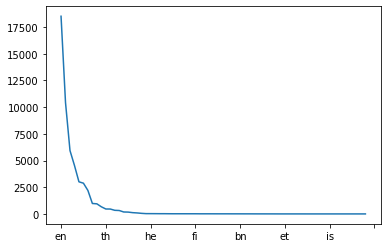

In [17]:
#labels distibution is heavily skewed
#some levels only occur once, we must likely upsample these categories.
label_dist = df_train["label"].value_counts()
print(label_dist)
print(label_dist.plot())

In [18]:
#number of unique labels of the data set
len(label_dist)

69

In [19]:
#There are no empty tweets or missing labels
print(df_train[df_train["tweet"].isna()].shape)
print(df_train[df_train["label"].isna()].shape)

(0, 2)
(0, 2)


In [20]:
# clean the tweets according to the process of the PreProcessing object
df_train = PP.clean_tweets(df_train)
df_train.sample(10)

,tweet,label
47620,kıyamet gu nu neler yas anacak muhtes em ses e...,tr
19144,these are the clubs that have sailed too close...,en
41536,才て もタ ンスか て きるんた 笑 私もそのく らいまて か んは ろ笑,ja
43845,e a esta de parabe ns pelo servic o terceira i...,pt
27160,j utilise pluto t tweetdeck et c a marche bie...,fr
47741,cumhur bizsek reis sensin usta,tr
44673,minha,pt
22148,ya es tt jaajajjaja te amo,es
421,مش كل اللي عندهم فولورز بالا لاف وكاتبين ا حاد...,ar
2375,apoll im blitzlicht neues scanverfahren will k...,de


In [21]:
#augment labels according to the procedure from the DataAugmentation object
df_train = DA.augment_labels(df_train, min_labels = 1000)
df_train.shape

(107627, 2)

In [22]:
df_train.sample(10)

,tweet,label
221,loko haha sinabihan kitang cute kaya sabay uli...,tl
44219,ah fala se rio eu coloquei primeiro que vc ne...,pt
497,این روزهایم به تظاهر می گذرد تظاهر اما بی تفاو...,fa
513,ह र क थ य कह ल ट न क,ne
21807,gracias miamor,es
713,a legido sebb nyugdi jas e ves a legto bb nyug...,hu
46059,вся мощь и красота природы в фотографиях,ru
811,tobann komikku yakinbyotou ni furuedisyonn ope...,ja_LATN
19061,if anal is considered sex then so is taking a...,en
495,بستنی یه روز اومدید ایتالیا هی راه نیفتید دنبا...,fa


In [23]:
#split training data into train and validation using a 90/10 split and with shuffeling
#note we are using preprocessed and augmented data.
X_train, X_validation, y_train, y_validation = train_test_split(df_train["tweet"], df_train["label"], test_size=0.1, shuffle=True)

In [24]:
print(f"Length of the training set: {len(X_train)}")
print(f"Length of the validation set: {len(X_validation)}")

Length of the training set: 96864
Length of the validation set: 10763


In [25]:
#make a pipeline that engineers the length-of-a-tweet feature
tweet_length = Pipeline([
    ("numtans", NumCharTransformer()),
    ("scale", StandardScaler())
])

In [26]:
#create a pipeline that engineers the Bag-of-words
#note that clean_tweets() was not put into the pipeline (could be done with functionTransformer())
#this is because it has no parameters to tweak and it would possibly create overhead with GridSearchCV
bag_of_words = Pipeline([
    ('vect', CountVectorizer(
        lowercase = False, 
        encoding='utf-8',
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None
        )),
    ('feature_selector', SelectKBest(
        chi2, 
        k=50000
        )),
    ('tfidf', TfidfTransformer(
        smooth_idf=True
        ))
])

In [27]:
#FeatureUnion is used to append the bag-of-words matrix to the tweet-length vector
#both must have appropriate dimensionality
all_features = FeatureUnion([
    ("len", tweet_length),
    ("bagger", bag_of_words)
])

In [28]:
#train the logistic regression model on the engineered features
pipeline = Pipeline([
   ("all", all_features),
   ('logreg', LogisticRegression()) 
])
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('all',
                 FeatureUnion(transformer_list=[('len',
                                                 Pipeline(steps=[('numtans',
                                                                  NumCharTransformer()),
                                                                 ('scale',
                                                                  StandardScaler())])),
                                                ('bagger',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(lowercase=False)),
                                                                 ('feature_selector',
                                                                  SelectKBest(k=50000,
                                                                              score_func=<function chi2 at 0x7f6c714bec20>)),
                                                          

In [ ]:
#repeated K-fold Crossvalidation to get robust estimates
#note this has not been run as it would take too much time
scores = cross_val_score(pipeline, X_train, y_train, cv = RepeatedKFold(n_splits=5))
print(f"mean accuracy from crossvalidation {scores.mean()}")
print(f"standard deviation from crossvalidation {scores.std()}")

In [29]:
print(f"Performance on Training Data: {pipeline.score(X_train, y_train)}")
print(f"Performance on Validation Data: {pipeline.score(X_validation, y_validation)}")

Performance on Training Data: 0.9287248100429468
Performance on Validation Data: 0.9126637554585153


In [ ]:
#here model parameters are being tuned
#further some parameters of the CountVectorizer are also being tuned.
pipeline_parameters = {
    "all__bagger__vect__ngram_range": [(1,1), (1,2), (1,3), (1,4)],
    "all__bagger__vect__analyzer": ["word", "char", "char_wb"],
    "logreg__penalty": ["l1", "l2", "elasticnet", "none"],
    "logreg__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}

grid = GridSearchCV(pipeline, 
                    pipeline_parameters,
                    cv = 10
                    )
grid.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [30]:
#see model prediction on test dataset

#the dataset is cleaned with the same procedure as the training data
#trivially, upsampling would not be of any use here.
df_test = PP.clean_tweets(df_test)

X_test, y_test = df_test["tweet"], df_test["label"]
print(f"Performance on Test Data: {pipeline.score(X_test, y_test)}")

Performance on Test Data: 0.8449454088445527


In [31]:
#confusion matrix of out of sample results
y_pred_test = pd.Series(pipeline.predict(X_test))
conf_matr = confusion_matrix(y_test, y_pred_test, normalize = None)
conf_matr

array([[406,   1,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

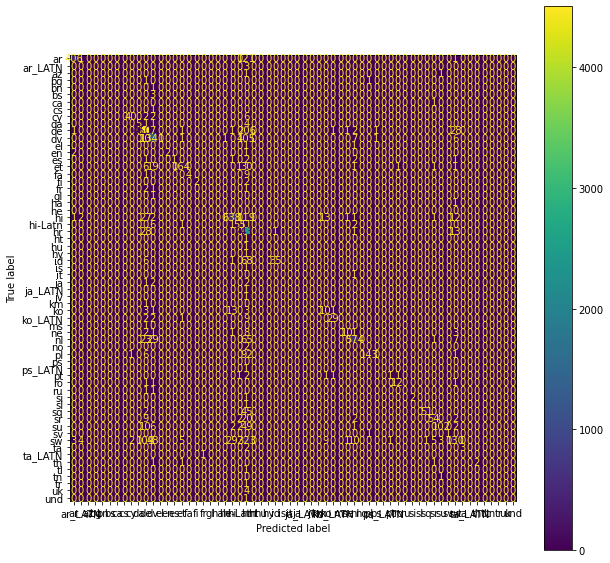

In [32]:
#Plot the confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matr,
                              display_labels = pipeline.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

In [33]:
#accuracy per label
print(classification_report(y_test, y_pred_test))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

          ar       0.98      0.77      0.86       529
     ar_LATN       0.00      0.00      0.00         3
          az       0.00      0.00      0.00         2
          bg       0.00      0.00      0.00         2
          bs       0.00      0.00      0.00         1
          ca       0.00      0.00      0.00         3
          cs       0.00      0.00      0.00         1
          da       0.00      0.00      0.00         1
          de       0.93      0.80      0.86        50
          el       1.00      0.45      0.62        11
          en       0.95      0.95      0.95      4756
          es       0.91      0.91      0.91      1476
          eu       0.00      0.00      0.00         2
          fa       1.00      0.40      0.57         5
          fi       1.00      0.12      0.22         8
          fr       0.94      0.73      0.82       224
          he       1.00      0.29      0.44        14
          hi       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# get feature names from "vect" (as tfidf overwrites feature names with x[integer]), delete the ones not selected from the 
# "feature_selector"
mask = bag_of_words.named_steps["feature_selector"].get_support()
feature_names_vect = bag_of_words.named_steps["vect"].get_feature_names_out()
feature_names_vect = feature_names_vect[mask]

# Insert the length-of-tweet at position 0 of the np.array (as this is the procedure in FeatureUnion)
feature_names = np.insert(feature_names_vect, 0, "tweet_length")

# plot the importance table
eli5.show_weights(pipeline.named_steps["logreg"], top=10, targets = ["en", "es", "ja"], feature_names = feature_names, include_styles = True)